# Chapter boundaries

Comparing chapter boundaries to other, unmarked moments in 19c fiction.

In [2]:
import torch.nn.functional as F
from torch import Tensor
import torch 
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import pandas as pd
import sys, json, math, os
import numpy as np
print('First imports complete.')

def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-base")
model = AutoModel.from_pretrained("thenlper/gte-base")
model.eval()
model.to(device)

print('Tokenizer and model built.')

import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

print('NLTK downloaded.')

First imports complete.
Using cpu
Tokenizer and model built.
NLTK downloaded.


[nltk_data] Downloading package punkt to /Users/tunder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def load_data(filepath):
    in_df = pd.read_csv(filepath, sep = '\t')
    in_df = in_df.loc[ : , ['mode', 'text', 'chunkindex']]
    print(in_df.shape)
    return in

In [7]:
data = pd.read_csv('out/CopperCylinder.tsv', sep = '\t')
data.head()

,filename,title,author,mode,text,wordindex,sentindex,passindex,chunkindex,recaplen,recaptext,passage_length,divide_type
0,chapterbooks/CopperCylinder.txt,A Strange Manuscript Found in a Copper Cylinder,James De Mille,summary,A group of friends on a yacht in the 1850s dec...,918,53,0,0,0,NaN,918,sentence
1,chapterbooks/CopperCylinder.txt,A Strange Manuscript Found in a Copper Cylinder,James De Mille,prediction,"As the paper boats float in the water, a sudde...",918,53,0,1,0,NaN,918,sentence
2,chapterbooks/CopperCylinder.txt,A Strange Manuscript Found in a Copper Cylinder,James De Mille,summary,A group of friends on a yacht discover a cylin...,1797,114,0,1,34,NaN,879,sentence
3,chapterbooks/CopperCylinder.txt,A Strange Manuscript Found in a Copper Cylinder,James De Mille,prediction,"Intrigued by the copper cylinder they found, t...",1797,114,0,2,34,A group of friends on a yacht in the 1850s dec...,879,sentence
4,chapterbooks/CopperCylinder.txt,A Strange Manuscript Found in a Copper Cylinder,James De Mille,summary,The friends on the yacht open the cylindrical ...,2621,167,0,2,59,NaN,824,HN


In [3]:
def avg_cosine(a, b):
    the_cosines = []
    for embed_a in a:
        for embed_b in b:
            the_cosines.append(cosine(embed_a, embed_b))
    return np.mean(the_cosines)

def bottom_half_cosines(a, b, c):
    the_cosines = []
    for embed_a in a:
        for embed_b in b:
            the_cosines.append(cosine(embed_a, embed_b))
        for embed_c in c:
            the_cosines.append(cosine(embed_a, embed_c))
    the_cosines.sort()
    number_to_take = math.ceil(len(the_cosines) * .4)
    return np.mean(the_cosines[0 : number_to_take])

In [4]:
def process_sentence(sentence):
    # Split the sentence at semicolons
    parts = sentence.split(';')

    # Uppercase the first letter of each part and strip leading/trailing spaces
    processed_parts = [part.strip().capitalize()+'.' for part in parts]

    return ' '.join(processed_parts)

# Example usage
sentence = "this is a test;here is another test;and yet another test"
processed_sentence = process_sentence(sentence)
print(processed_sentence)


This is a test. Here is another test. And yet another test.


In [5]:
def get_distances(filepath):    
    
    data = pd.read_csv(filepath, sep = '\t')
    
    prediction_sentences = []
    summary_sentences = []
    positions = []
    divide_types = []
    maxword = max(data['wordindex'])
    sum_lengths = []
    predict_lengths = []

    ctr = 0
    for i in [0, 1, 2, 3]:
        maxchunk = max(data.loc[data['passindex'] == i, 'chunkindex'])
        for j in range(1, maxchunk):
            predict_text = ' '.join(data.loc[(data['passindex'] == i) & (data['chunkindex'] == j) & (data['mode'] == 'prediction'), 'text'].values)
            summary_text = ' '.join(data.loc[(data['passindex'] == i) & (data['chunkindex'] == j) & (data['mode'] == 'summary'), 'text'].values)
            sum_lengths.append(len(summary_text))
            predict_lengths.append(len(predict_text))
            predict_text = process_sentence(predict_text)
            summary_text = process_sentence(summary_text)

            prediction_sentences.append(list(sent_tokenize(predict_text)))
            summary_sentences.append(list(sent_tokenize(summary_text)))
            thisword = int(data.loc[(data['passindex'] == i) & (data['chunkindex'] == j) & (data['mode'] == 'prediction'), 'wordindex'].values[0])
            positions.append(thisword/maxword)
            divide_types.append(data.loc[(data['passindex'] == i) & (data['chunkindex'] == j) & (data['mode'] == 'prediction'), 'divide_type'].values[0])
            
            ctr += 1
    
    summary_embeddings = []
    prediction_embeddings = []
    
    print(len(summary_sentences))

    with torch.no_grad():   # save memory
        for i in range(len(summary_sentences)):
            # print(summary_sentences[i])
            # Tokenize and move to device
            batch_dict = tokenizer(summary_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

            # Generate embeddings
            outputs = model(**batch_dict)
            raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            embeddings = F.normalize(raw_embeddings, p=2, dim=1)

            # Append to master list
            summary_embeddings.append(embeddings)
            if i%10 == 1:
                print(i)

            # Tokenize and move to device
            batch_dict = tokenizer(prediction_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

            # Generate embeddings
            outputs = model(**batch_dict)
            raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            embeddings = F.normalize(raw_embeddings, p=2, dim=1)

            # Append to master list
            prediction_embeddings.append(embeddings)
    
    numrows = len(summary_embeddings)
    samechunk = []
    
    distance = np.zeros((numrows, numrows), dtype=float)
    
    for i in range(numrows):
        for j in range(numrows):
            distance[i, j] = avg_cosine(prediction_embeddings[i], summary_embeddings[j])
            if i == j:
                samechunk.append(distance[i, j])
        
    return numrows, distance, samechunk, positions, divide_types, sum_lengths, predict_lengths

In [215]:
numrows, samechunk, positions, divide_types, sum_lengths, predict_lengths = get_distances('out/CopperCylinder.tsv')

374
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371


In [216]:
from scipy.stats import pearsonr

In [218]:
pearsonr(samechunk, sum_lengths)

(0.047061270142991586, 0.36410118768269584)

In [29]:
import seaborn as sns

In [32]:
positions[0:10]

[0.010526315789473684,
 0.021052631578947368,
 0.031578947368421054,
 0.042105263157894736,
 0.05263157894736842,
 0.06315789473684211,
 0.07368421052631578,
 0.08421052631578947,
 0.09473684210526316,
 0.10526315789473684]

<AxesSubplot:xlabel='position', ylabel='distance'>

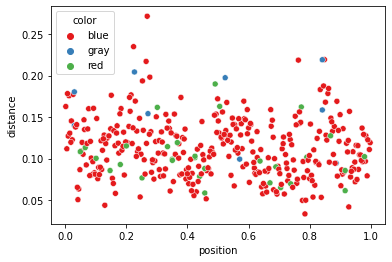

In [115]:
colors = []
for dt in divide_types:
    if dt == 'sentence':
        colors.append('blue')
    elif 'N' in dt:
        colors.append('gray')
    else:
        colors.append('red')
df = pd.DataFrame({'position': positions, 'distance': samechunk, 'color': colors})
sns.scatterplot(data = df, x = 'position', y = 'distance', hue = 'color', palette = 'Set1')

In [67]:
divide_types[0:10]

[array(['sentence'], dtype=object),
 array(['sentence'], dtype=object),
 array(['HN'], dtype=object),
 array(['sentence'], dtype=object),
 array(['sentence'], dtype=object),
 array(['sentence'], dtype=object),
 array(['sentence'], dtype=object),
 array(['sentence'], dtype=object),
 array(['sentence'], dtype=object),
 array(['sentence'], dtype=object)]

In [219]:
ordinary = []
chapters = []
pov = []
for dt, dist in zip(divide_types, samechunk):
    
    if dt == 'sentence':
        ordinary.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'N' in dt:
        pov.append(dist)
    else:
        chapters.append(dist)

In [220]:
from scipy.stats import ttest_ind

In [221]:
ttest_ind(ordinary, chapters)

Ttest_indResult(statistic=0.9484246892000647, pvalue=0.3435442577607305)

In [222]:
len(pov)

9

In [223]:
np.mean(ordinary)

0.11459509248460703

In [224]:
np.mean(chapters)

0.10816413660844167

In [225]:
np.mean(pov)

0.16377655002805921

In [126]:
numrows, samechunk3, positions3, divide_types3 = get_distances('out/LeaguesUnderGB.tsv')

631


/Users/tunder/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621


In [133]:
ordinary3 = []
chapters3 = []
install3 = []
for dt, dist in zip(divide_types3, samechunk3):
    
    if dt == 'sentence':
        ordinary3.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install3.append(dist)
    else:
        chapters3.append(dist)

EOF


In [134]:
ttest_ind(ordinary3, install3)

Ttest_indResult(statistic=-1.1520770784848842, pvalue=0.24974071073834497)

<AxesSubplot:xlabel='position', ylabel='distance'>

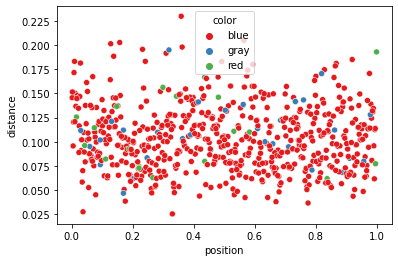

In [132]:
colors = []
for dt in divide_types3:
    if dt == 'sentence':
        colors.append('blue')
    elif 'I' in dt:
        colors.append('gray')
    else:
        colors.append('red')
df = pd.DataFrame({'position': positions3, 'distance': samechunk3, 'color': colors})
sns.scatterplot(data = df, x = 'position', y = 'distance', hue = 'color', palette = 'Set1')

In [135]:
np.mean(ordinary3)

0.10356696171744059

In [136]:
np.mean(chapters3)

0.10631703999307421

In [137]:
np.mean(install3)

0.11029775878962349

In [138]:
len(install3)

34

In [16]:
numrows, distance2, samechunk2, positions2, divide_types2, sum_lengths2, predict_lengths2 = get_distances('out/WomaninWhiteGB.tsv')

1087
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001
1011
1021
1031
1041
1051
1061
1071
1081


<AxesSubplot:xlabel='position', ylabel='distance'>

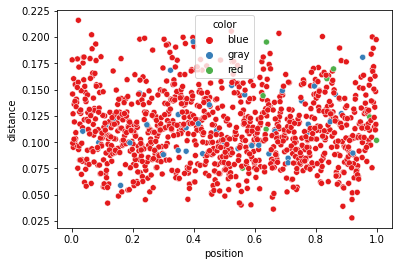

In [147]:
colors = []
for dt in divide_types2:
    if dt == 'sentence':
        colors.append('blue')
    elif 'I' in dt:
        colors.append('gray')
    else:
        colors.append('red')
df = pd.DataFrame({'position': positions2, 'distance': samechunk2, 'color': colors})
sns.scatterplot(data = df, x = 'position', y = 'distance', hue = 'color', palette = 'Set1')

In [47]:
ordinary2 = []
chapters2 = []
install2 = []
for dist, dt in zip(samechunk2, divide_types2):
    if dt == 'sentence':
        ordinary2.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install2.append(dist)
    else:
        chapters2.append(dist)

EOF


In [48]:
df = pd.DataFrame({'divergence': ordinary2 + install2 + chapters2, 
                   'type': ['midchapter'] * len(ordinary2) + ['end of serial part'] * len(install2) + ['other chapter break'] * len(chapters2)})

/Users/tunder/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  # Remove the CWD from sys.path while we load stuff.


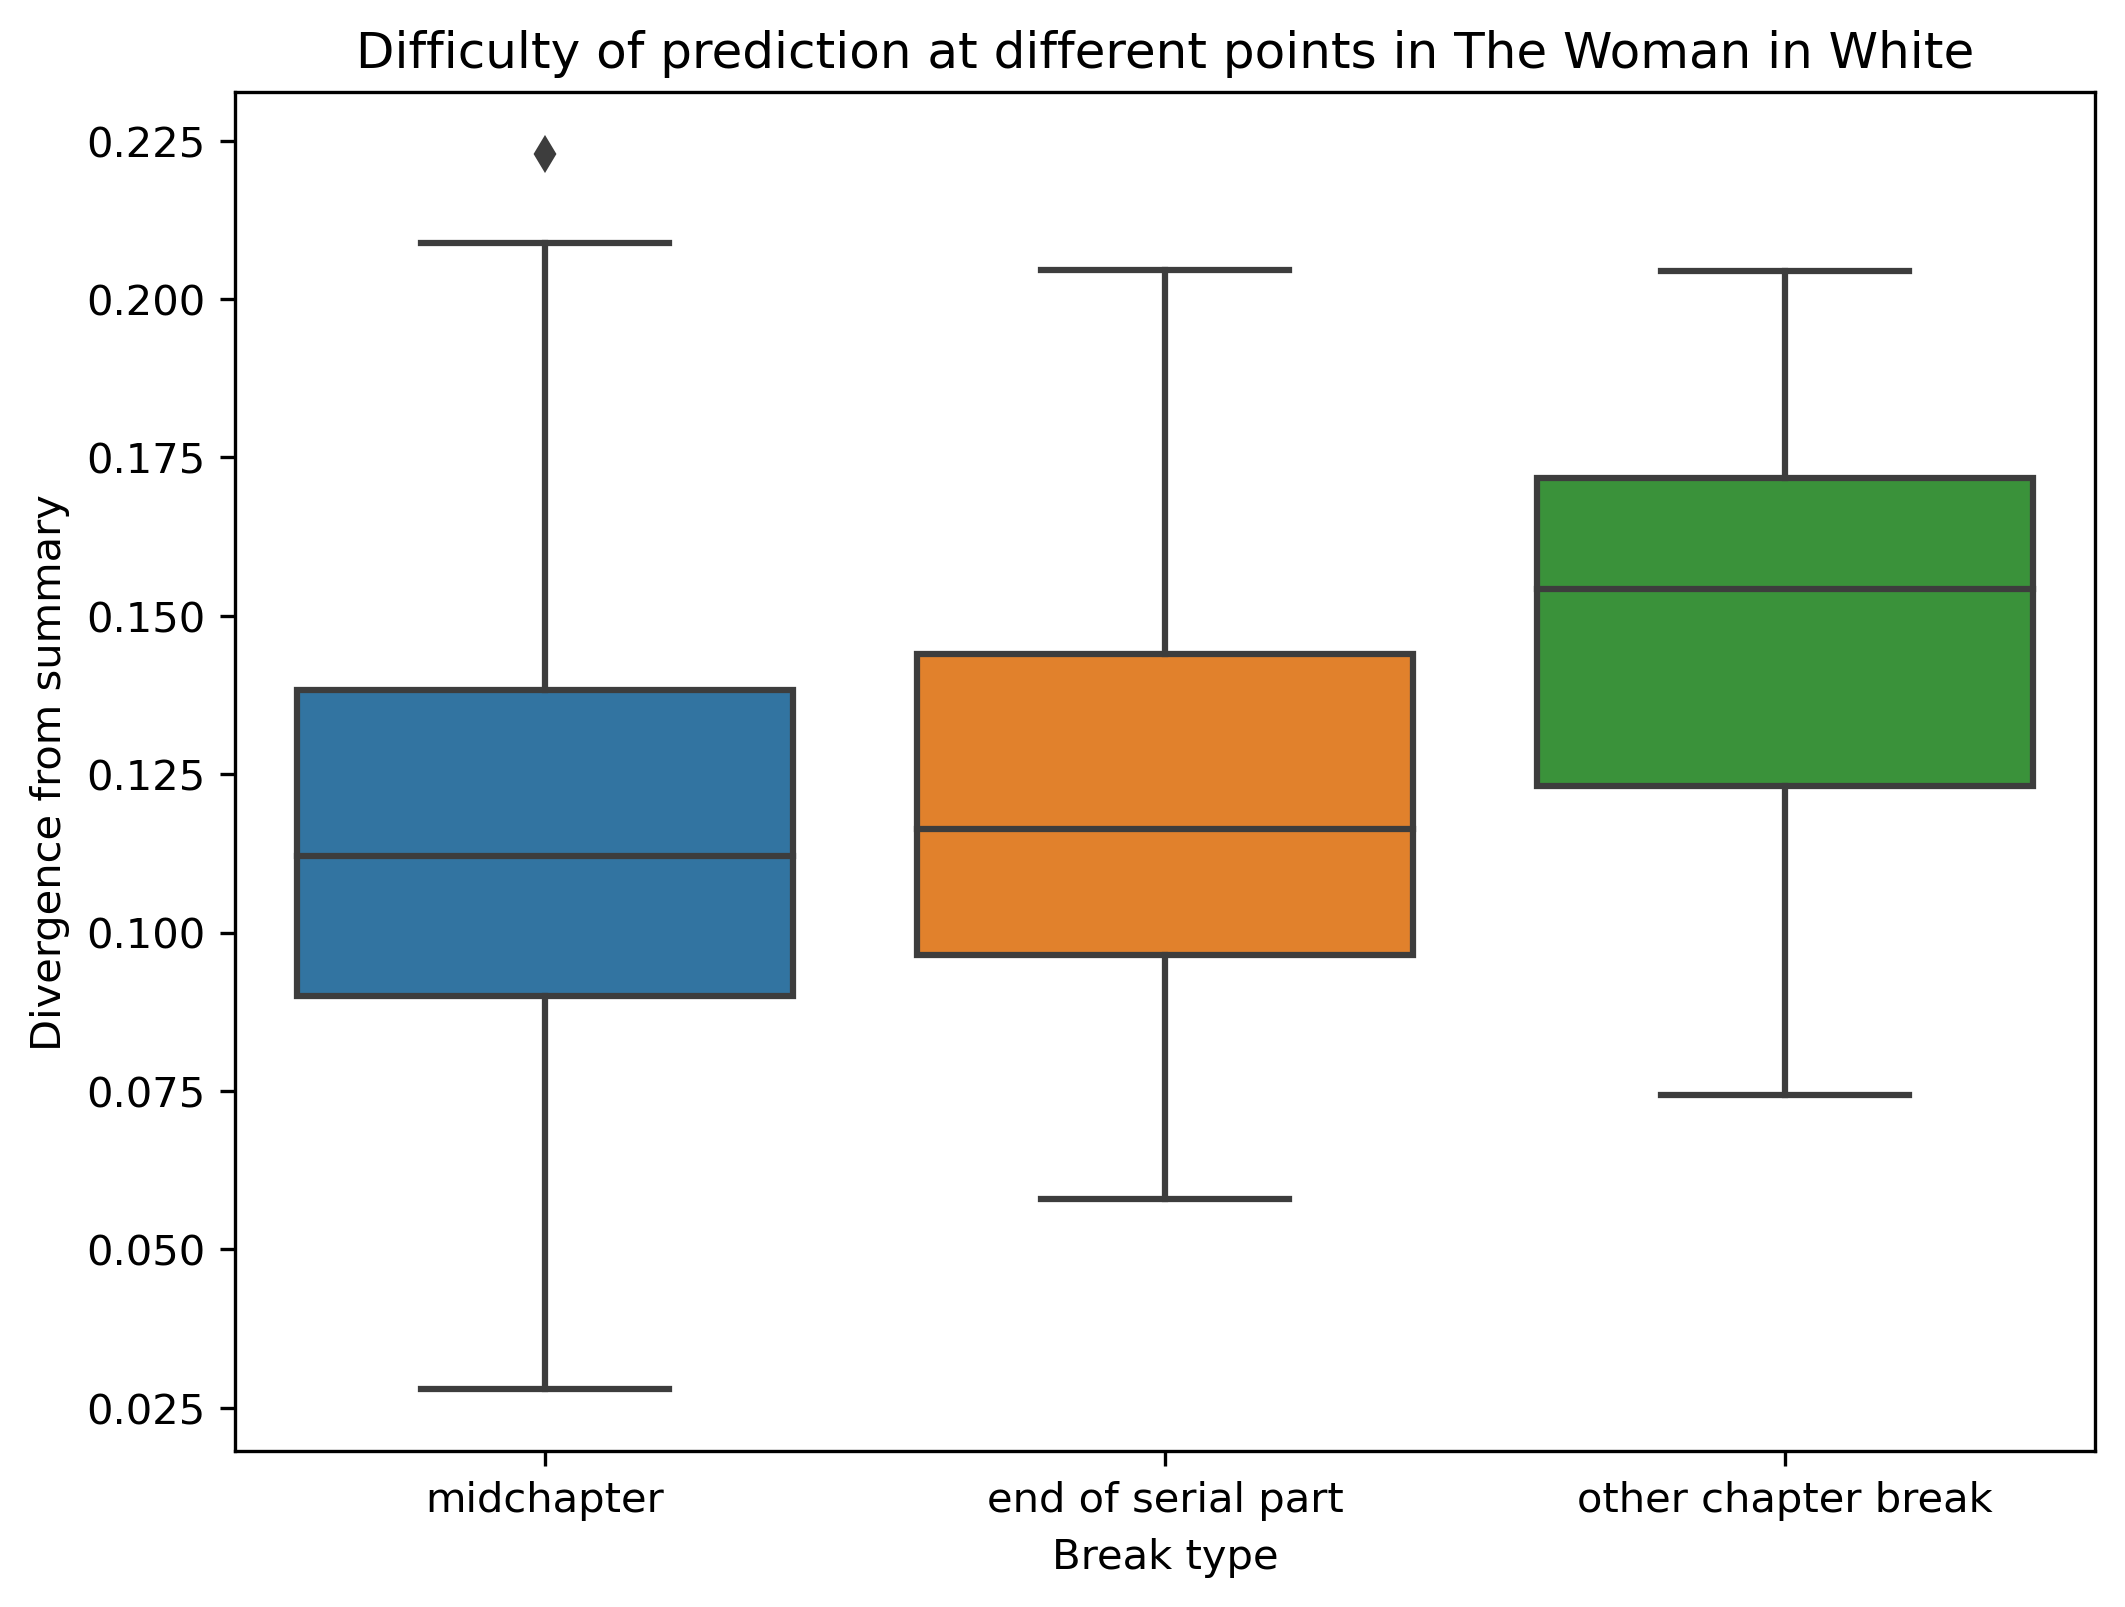

In [49]:
plt.figure(figsize=(8, 6), dpi = 300)

# Create the swarm plot
sns.boxplot(x='type', y='divergence', data=df)

# Optional: Set titles and labels
plt.title('Difficulty of prediction at different points in The Woman in White')
plt.xlabel('Break type')
plt.ylabel('Divergence from summary')
plt.savefig('WomanInWhiteBoxplot.jpg', format='jpg', dpi=300, quality=95, bbox_inches = 'tight')
# Show the plot
plt.show()

In [45]:
cohens_d(install2, chapters2 + ordinary2)

0.6479174403174036

In [46]:
len(install2)

13

In [42]:
ttest_ind(install2, chapters2 + ordinary2)

Ttest_indResult(statistic=2.322075277810981, pvalue=0.020413434075905262)

In [166]:
ttest_ind(ordinary2, install2)

Ttest_indResult(statistic=-2.4437018670406174, pvalue=0.014701826669352597)

In [167]:
np.mean(install2)

0.1346601935533377

In [168]:
np.mean(chapters2)

0.11551646025557268

In [169]:
np.mean(ordinary2)

0.11216380100895242

In [170]:
numrows, samechunk4, positions4, divide_types4 = get_distances('out/AuroraFloydGB.tsv')

812


/Users/tunder/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811


In [171]:
ordinary4 = []
chapters4 = []
install4 = []
for dist, dt in zip(samechunk4, divide_types4):
    if dt == 'sentence':
        ordinary4.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install4.append(dist)
    else:
        chapters4.append(dist)

In [180]:
ttest_ind(ordinary4 + ordinary3 + ordinary2 + ordinary, \
          install4 + chapters4 +install3 + chapters3 + install2 + chapters2 + chapters + pov)

Ttest_indResult(statistic=-2.3764683577511785, pvalue=0.017543823834933515)

In [173]:
len(install4)

13

In [178]:
np.mean(install4)

0.12021820820294894

In [181]:
np.mean(ordinary4 + ordinary3 + ordinary2 + ordinary)

0.10907619982935877

In [182]:
np.mean(install4 + chapters4 +install3 + chapters3 + install2 + chapters2 + chapters + pov)

0.11511941983344708

In [43]:
def cohens_d(group1, group2):
    # Calculate the mean and standard deviation of each group
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # Calculate the sample sizes
    n1, n2 = len(group1), len(group2)

    # Calculate the pooled standard deviation
    sd_pooled = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))

    # Calculate Cohen's d
    d = (mean1 - mean2) / sd_pooled

    return d



In [231]:
ordi = ordinary4 + ordinary3 + ordinary2 + ordinary + ordinary5 +ordinary6
special = install4 + chapters4 +install3 + chapters3 + install2 + chapters2 + chapters + pov +\
install5 + chapters5 + chapters6
superspecial = install4 + install3 +install2 + pov + install5
cohens_d(ordi, special)

-0.3025859977677042

In [198]:
cohens_d(superspecial, ordi)

0.38135847831105923

In [196]:
subspecial = chapters + chapters2 + chapters3 + chapters3 + chapters5
len(subspecial)

165

In [199]:
ttest_ind(subspecial, ordi)

Ttest_indResult(statistic=2.5320883833508954, pvalue=0.01137875823653137)

In [200]:
cohens_d(subspecial, ordi)

0.20157492657792234

In [189]:
numrows, samechunk5, positions5, divide_types5 = get_distances('out/LuttrellOfAranGB.tsv')

974
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971


In [190]:
ordinary5 = []
chapters5 = []
install5 = []
for dist, dt in zip(samechunk5, divide_types5):
    if dt == 'sentence':
        ordinary5.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install5.append(dist)
    else:
        chapters5.append(dist)

In [194]:
ttest_ind(install5 + chapters5, ordinary5)

Ttest_indResult(statistic=3.523440180120002, pvalue=0.0004458126768658564)

In [195]:
len(install5)

15

In [226]:
numrows, samechunk6, positions6, divide_types6, sum_lengths6, predict_lengths6 = get_distances('out/VanityFairGB.tsv')

1338
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001
1011
1021
1031
1041
1051
1061
1071
1081
1091
1101
1111
1121
1131
1141
1151
1161
1171
1181
1191
1201
1211
1221
1231
1241
1251
1261
1271
1281
1291
1301
1311
1321
1331


In [227]:
ordinary6 = []
chapters6 = []
install6 = []
for dist, dt in zip(samechunk6, divide_types6):
    if dt == 'sentence':
        ordinary6.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install6.append(dist)
    else:
        chapters6.append(dist)

In [228]:
ttest_ind(ordinary6, chapters6)

Ttest_indResult(statistic=-3.6945869059761187, pvalue=0.00022914043194174156)

In [229]:
ttest_ind(ordinary6, install6)

Ttest_indResult(statistic=nan, pvalue=nan)

In [230]:
pearsonr(samechunk6, sum_lengths6)

(-0.037421655560143534, 0.17130122678215812)

In [282]:
numrows, distance8, samechunk8, positions8, divide_types8, sum_lengths8, predict_lengths8 = get_distances('chapterout/OurMutualFriend.tsv')

1438
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001
1011
1021
1031
1041
1051
1061
1071
1081
1091
1101
1111
1121
1131
1141
1151
1161
1171
1181
1191
1201
1211
1221
1231
1241
1251
1261
1271
1281
1291
1301
1311
1321
1331
1341
1351
1361
1371
1381
1391
1401
1411
1421
1431


<AxesSubplot:>

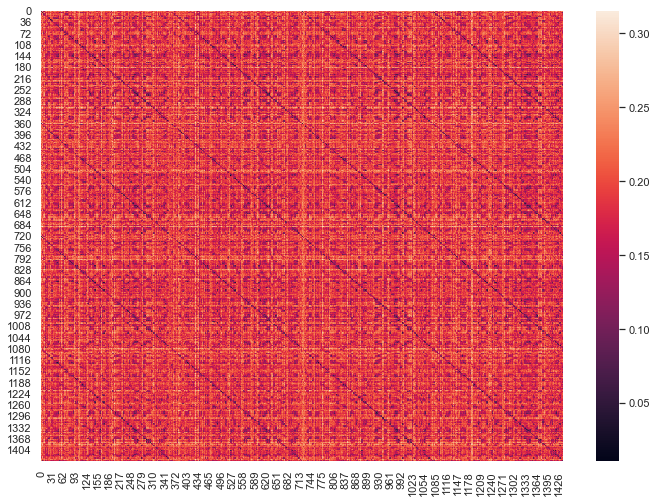

In [268]:
sns.heatmap(distance7)

In [302]:
tuplets = []

for i, p in enumerate(positions8):
    tuplets.append((p, i))

tuplets.sort()

sortmap = dict()

for i, tuplet in enumerate(tuplets):
    p, k = tuplet
    sortmap[k] = i

newdistance = np.zeros((numrows, numrows), dtype=float)
maxrows = len(tuplets)
for i in range(maxrows):
    for j in range(maxrows):
        newdistance[sortmap[i], sortmap[j]] = distance8[i, j]

<AxesSubplot:>

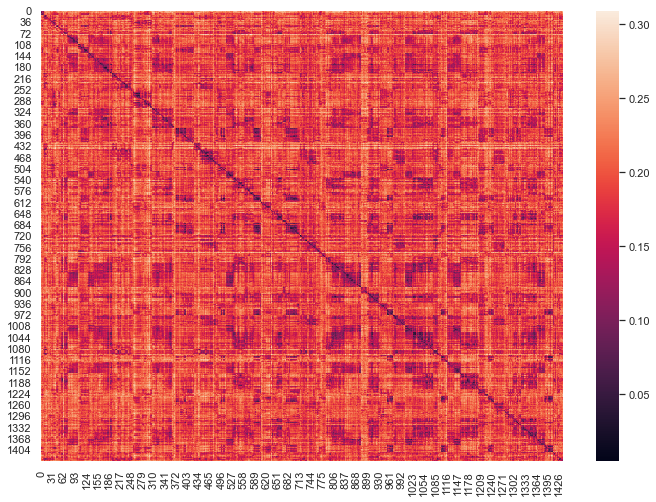

In [303]:
sns.heatmap(newdistance)

In [313]:
outdf = pd.DataFrame({'pos': positions8, 'dist': samechunk8, 'divide': divide_types8})
outdf.to_csv('chapterout/analysis/OMFpredict.tsv', sep = '\t', index = False)

In [283]:
ordinary8 = []
chapters8 = []
install8 = []
for dist, dt in zip(samechunk8, divide_types8):
    if dt == 'sentence':
        ordinary8.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install8.append(dist)
    else:
        chapters8.append(dist)

In [284]:
ttest_ind(ordinary8, chapters8)

Ttest_indResult(statistic=-10.354536416945907, pvalue=2.866420323775127e-24)

In [285]:
ttest_ind(ordinary8, install8)

Ttest_indResult(statistic=-6.239003755639242, pvalue=5.845237560523506e-10)

In [234]:
ttest_ind(ordinary7, chapters7)

Ttest_indResult(statistic=-6.790846992033339, pvalue=1.6365060866489223e-11)

In [287]:
pearsonr(samechunk8, positions8)

(-0.04606562419038729, 0.0807655869808646)

In [235]:
ttest_ind(ordinary7, install7)

Ttest_indResult(statistic=-4.0950007754873665, pvalue=4.466841679575092e-05)

<AxesSubplot:xlabel='position', ylabel='distance'>

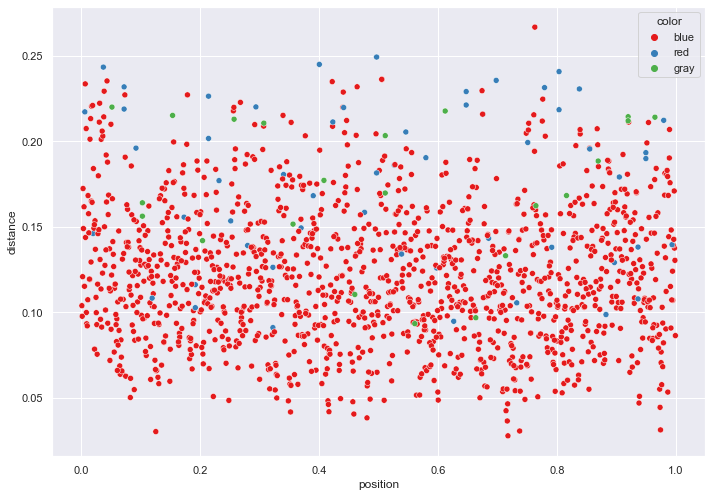

In [288]:
colors = []
sns.set(rc={'figure.figsize':(11.7,8.27)})
for dt in divide_types8:
    if dt == 'sentence':
        colors.append('blue')
    elif 'I' in dt:
        colors.append('gray')
    else:
        colors.append('red')
df = pd.DataFrame({'position': positions8, 'distance': samechunk8, 'color': colors})
sns.scatterplot(data = df, x = 'position', y = 'distance', hue = 'color', palette = 'Set1')

In [289]:
tuplets = [x for x in zip(positions8, samechunk8)]


[(0.0028526706739897562, 0.17224615812301636),
 (0.005828833584948766, 0.21706628799438477),
 (0.008378948278363852, 0.09973812103271484),
 (0.011225444340505144, 0.1681268811225891),
 (0.014093551544116059, 0.11906158924102783),
 (0.016779507698197322, 0.16488981246948242),
 (0.01972788485583825, 0.14596134424209595),
 (0.022166856535981008, 0.0783337950706482),
 (0.025072011410682694, 0.0996517539024353),
 (0.027927769390596685, 0.1458776593208313)]

In [290]:
tuplets.sort()
tuplets[0:10]

[(0.0008520964350878493, 0.10374778509140015),
 (0.0013985495836767961, 0.09755194187164307),
 (0.00209936802847731, 0.12070059776306152),
 (0.0028526706739897562, 0.17224615812301636),
 (0.0034207349640483224, 0.14883530139923096),
 (0.004492030119756597, 0.16156786680221558),
 (0.005236070847496349, 0.11509191989898682),
 (0.005828833584948766, 0.21706628799438477),
 (0.006511128194203892, 0.2334226369857788),
 (0.006961874859141667, 0.14364254474639893)]

In [299]:
moveavg = []
positionseq = []

chapterpositions = []
chaptermoveavg = []

for i in range(len(tuplets)):
    start = i - 1
    if start < 0:
        start = 0
    end = i + 2
    if end > len(tuplets):
        end = len(tuplets)
    toaverage = []
    for j in range(start, end):
        pos, dis = tuplets[j]
        toaverage.append(dis)
    moveavg.append(np.mean(toaverage))
    positionseq.append(tuplets[i][0])
    
    if divide_types8[i] != 'sentence':
        # print(divide_types7[i])
        chaptermoveavg.append(np.mean(toaverage))
        chapterpositions.append(tuplets[i][0])
        
        
    

<AxesSubplot:xlabel='position', ylabel='distance'>

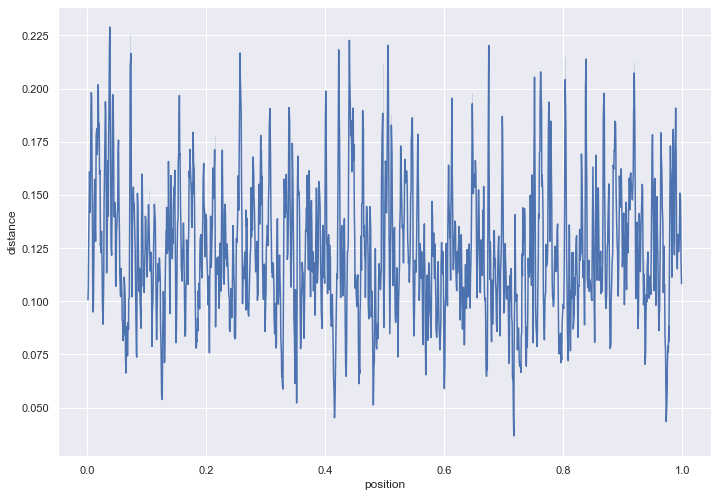

In [300]:
plotdf = pd.DataFrame({'position': positionseq, 'distance': moveavg})
sns.lineplot(data = plotdf, x = 'position', y = 'distance')

In [293]:
from matplotlib import pyplot as plt

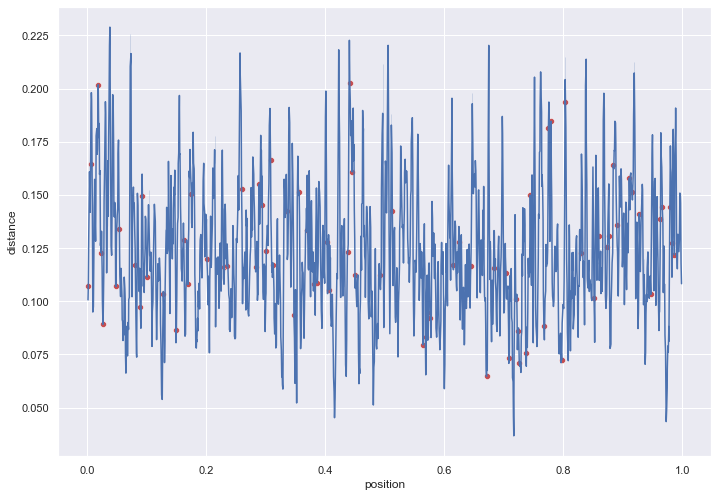

In [301]:
fig, ax = plt.subplots(figsize = (11.7,8.27))
plotdf = pd.DataFrame({'position': positionseq, 'distance': moveavg})
p1 = sns.lineplot(data = plotdf, x = 'position', y = 'distance', ax = ax)
plotdfB = pd.DataFrame({'position': chapterpositions, 'distance': chaptermoveavg})
p2 = sns.scatterplot(data = plotdfB, x = 'position', y = 'distance', color = 'r', ax = ax)

In [6]:
numrows, distance9, samechunk9, positions9, divide_types9, sum_lengths9, predict_lengths9 = get_distances('chapterout/HoundOfTheBaskervilles.tsv')

261


/Users/tunder/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251


In [7]:
ordinary9 = []
chapters9 = []
install9 = []
for dist, dt in zip(samechunk9, divide_types9):
    if dt == 'sentence':
        ordinary9.append(dist)
    elif dt == 'EOF':
        print('EOF')
    elif 'I' in dt:
        install9.append(dist)
    else:
        chapters9.append(dist)

In [33]:
df2 = pd.DataFrame({'divergence': ordinary9 + install9 + chapters9, 
                   'type': ['midchapter'] * len(ordinary9) + ['end of serial part'] * len(install9) + ['other chapter'] * len(chapters9)})

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

/Users/tunder/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  # Remove the CWD from sys.path while we load stuff.


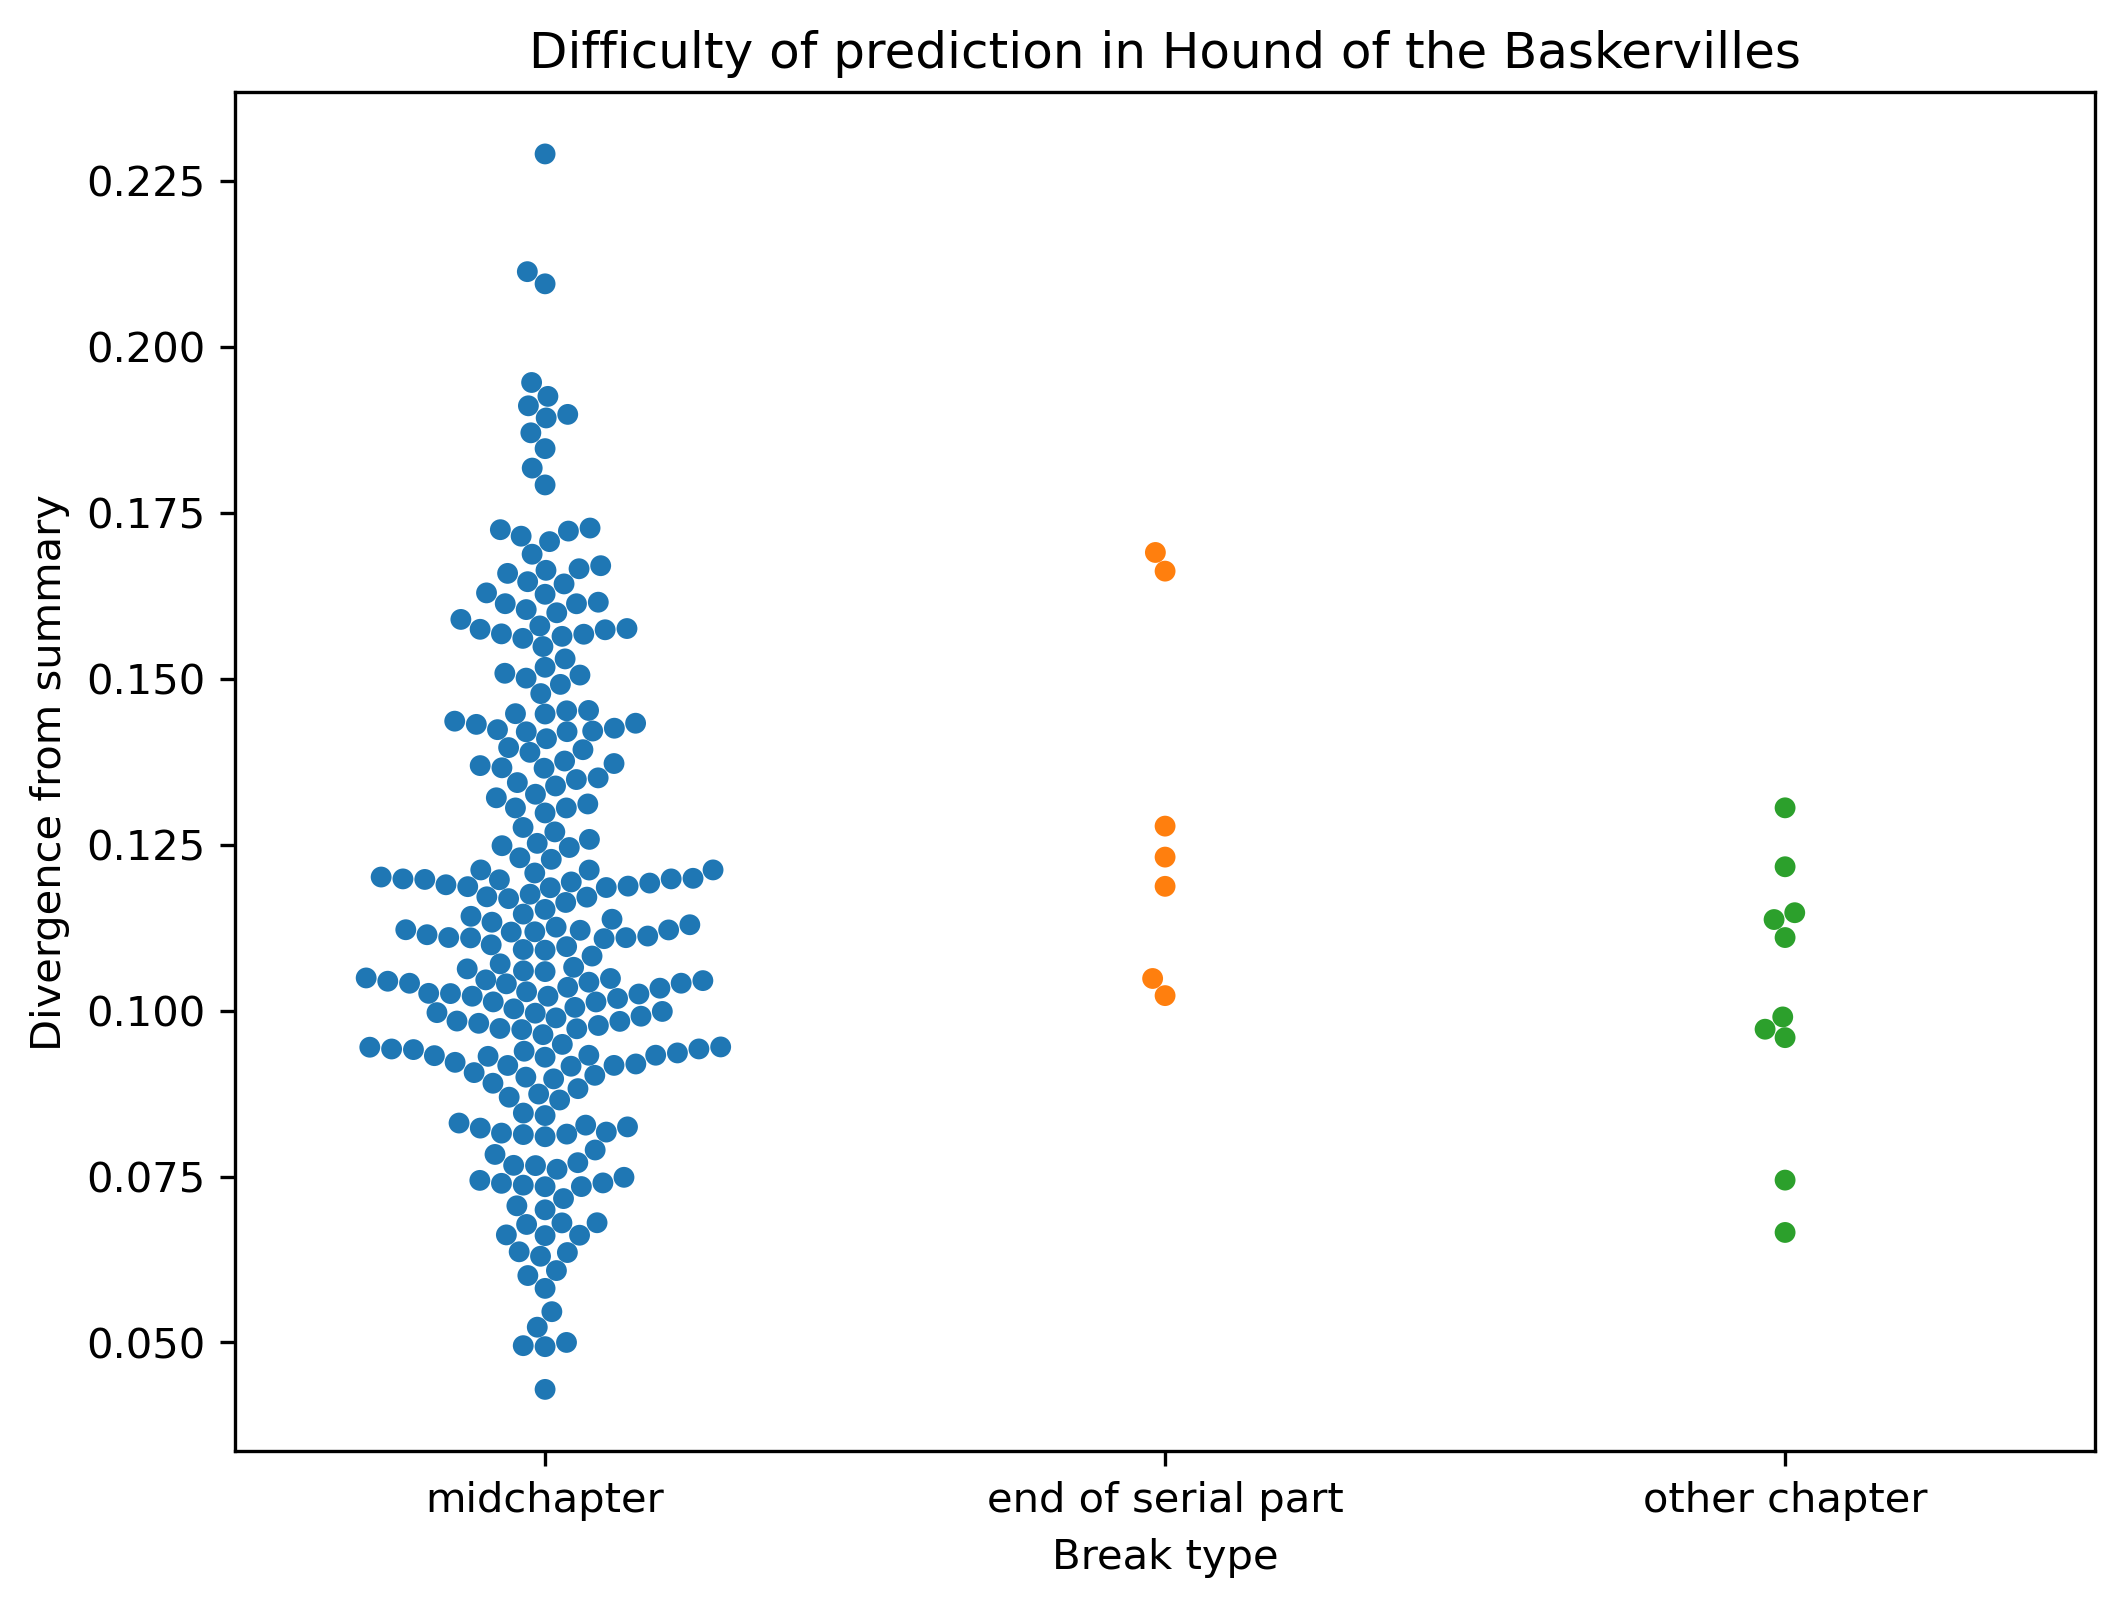

In [34]:
plt.figure(figsize=(8, 6), dpi = 300)

# Create the swarm plot
sns.swarmplot(x='type', y='divergence', data=df2)

# Optional: Set titles and labels
plt.title('Difficulty of prediction in Hound of the Baskervilles')
plt.xlabel('Break type')
plt.ylabel('Divergence from summary')
plt.savefig('BaskervillesSwarmplot.jpg', format='jpg', dpi=300, quality=95, bbox_inches = 'tight')
# Show the plot
plt.show()

In [38]:
from scipy.stats import ttest_ind

In [50]:
cohens_d(install9, chapters9)

1.1975829561013998

In [36]:
install9

[0.16617862383524576,
 0.10224384069442749,
 0.10482418537139893,
 0.11870399117469788,
 0.16899117827415466,
 0.12310671806335449,
 0.12777316570281982]

In [308]:
np.mean(install9)

0.13026024330229985

In [309]:
ttest_ind(chapters9, ordinary9)

Ttest_indResult(statistic=-1.231773186143487, pvalue=0.21918199199632316)

<AxesSubplot:xlabel='x', ylabel='y'>

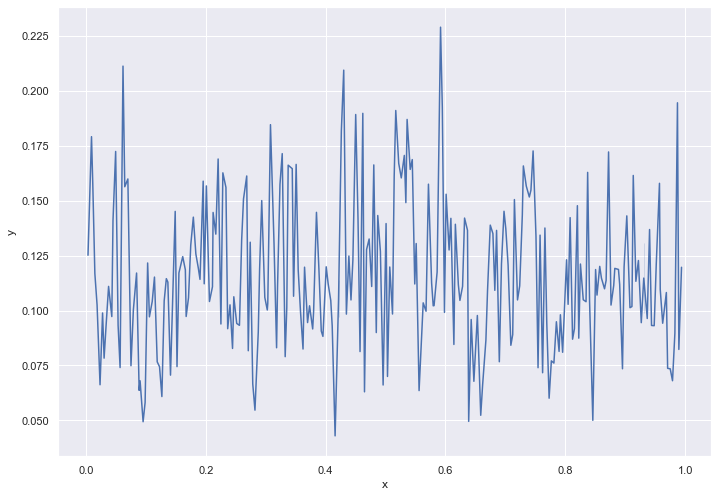

In [311]:
sns.lineplot(data = pd.DataFrame({'x': positions9, 'y': samechunk9}), x = 'x', y = 'y')

In [312]:
pearsonr(positions9, samechunk9)

(-0.013056094764214014, 0.8337268410957295)

In [314]:

numrows, distance10, samechunk10, positions10, divide_types10, sum_lengths10, predict_lengths10 = get_distances('chapterout/Persuasion.tsv')

369


/Users/tunder/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361


In [315]:
ordinary10 = []
chapters10 = []

for dist, dt in zip(samechunk10, divide_types10):
    if dt == 'sentence':
        ordinary10.append(dist)
    elif dt == 'EOF':
        print('EOF')
    else:
        chapters10.append(dist)

In [316]:
ttest_ind(chapters10, ordinary10)

Ttest_indResult(statistic=0.45096876322577434, pvalue=0.6522783941464529)